# 1. 数の表現と誤差

## 概要

- コンピューターは、浮動小数点という形式のbit列で実数を表現している。
- 列の長さと計算時間が有限という制約から発生する誤差をまとめる

## Key-words

- float
- overflow, underflow
- absolute error, relative error
- rounding error
- 桁落ち
- 情報落ち
- 打ち切り誤差
- 離散化誤差

### Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


### Python

In [2]:
!python3 -V

Python 3.7.4


### Import

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd
import sys

## Table of Contents

1. [二進法](#二進法)
    - [ホーナー法](#ホーナー法)
2. [Fixed point number](#Fixed_point_number)
    - [浮動小数点演算とPython](#浮動小数点演算とPython)
    - [オーバーフローとアンダーフロー](#オーバーフローとアンダーフロー)
    - [計算機イプシロン](#計算機イプシロン)
    - [IEEE単精度表現の相対誤差](#IEEE単精度表現の相対誤差の程度)
3. [Decimal](#Decimal)
4. [誤差](#誤差)
    - [誤差の原因](#誤差の原因)
    - [丸め誤差](#丸め誤差)
    - [多項式の計算に伴う丸め誤差の見積もり](#多項式の計算に伴う丸め誤差の見積もり)
    - [桁落ち](#桁落ち:cancellation)
    - [情報落ち](#情報落ち)
    - [打ち切り誤差](#打ち切り誤差)
    - [離散化誤差](#離散化誤差)
    - [シンプソンの公式](#シンプソンの公式)
    - [Aitken's Delta squared method](#収束速度の加速)
5. [演習問題](#演習問題)


## 二進法
### [例題１]

2進数00101001を10進数で表せ

In [4]:
def binary_to_decimal(x):
    import re
    
    if not isinstance(x, str):
        raise ValueError('引数が文字列ではありません')
    condition_1 = re.findall('\D|[2-9]', x)
    
    if condition_1:
        print(condition_1)
        raise ValueError('引数に不正な文字列が入っています')
    
    res = 0
    length = len(x) - 1
    for i, j in enumerate(x):
        i = length - i
        res += int(j) * (2 ** (i))
        
    return res

In [5]:
binary_to_decimal('00101001')

41

In [6]:
def binary_to_decimal_2(x):
    import re
    if not isinstance(x, str):
        raise ValueError('引数が文字列ではありません')
    condition_1 = re.findall('\D|[2-9]', x)
    
    if condition_1:
        print(condition_1)
        raise ValueError('引数に不正な文字列が入っています')
    
    x = int(x)
    base = 0
    res = 0
    while x:
        digit = x % 10
        res += (2 ** base) * digit
        
        base += 1
        x = int(x / 10)
        
    return res

In [7]:
binary_to_decimal_2('00101001')

41

In [8]:
%%timeit -r 3 -n 1000
binary_to_decimal('00101001')

6.68 µs ± 152 ns per loop (mean ± std. dev. of 3 runs, 1000 loops each)


In [9]:
%%timeit -r 3 -n 1000
binary_to_decimal_2('00101001')

5.54 µs ± 261 ns per loop (mean ± std. dev. of 3 runs, 1000 loops each)


### ホーナー法

以下のn次の代数方程式を解くときの演算回数を考える．

$$
f(x) = a_0x^n + ... + a_{n - 1}x + a_n
$$

普通にそれぞれの項を計算して、最後に足し合わせる計算方法を取ると乗算回数が$n(n+1)/2$, 加算回数がn回。一方ホーナー法では

$$
f(x) = (...((a_0x + a_1)x + a_2)x + .... + a_{n -2})x + a_{n - 1}) + a_n
$$、

として計算するので乗算回数、加算回数それぞれn回ずつとなる。

In [10]:
def hornor_binary_to_decimal(x):
    res = int(x[0])
    n = len(x)
    for i in range(1, n):
        
        res = res*2 + int(x[i])
        
    return res

In [11]:
hornor_binary_to_decimal('00101001')

41

In [12]:
%%timeit -r 3 -n 1000
hornor_binary_to_decimal('00101001')

4.81 µs ± 722 ns per loop (mean ± std. dev. of 3 runs, 1000 loops each)


hornor's ruleを用いると速い

### [例題２]

10進数41を2進数で表せ

In [13]:
def decimal_to_binary(x):
    quotient, remainder = divmod(x, 2)
    res = str(remainder)
    while quotient > 0:
        quotient, remainder = divmod(quotient, 2)
        res = str(remainder) + res
    
    return res
    

In [14]:
decimal_to_binary(41)

'101001'

In [15]:
%%timeit -r 3 -n 1000
decimal_to_binary(41)

3.29 µs ± 549 ns per loop (mean ± std. dev. of 3 runs, 1000 loops each)


### [例題3]

2進数0.1100を10進数で表せ

In [16]:
def binary_to_decimalpoint(x, point = 7):
    """
    x should be smaller than 1 and positive 
    """
    eps = eval('1e-' + str(point - 1))
    base = 1
    res = 0
    while abs(x - 0) > eps:
        x = 10*x
        res += ((1/2)**base) * int(x)
        x = round(x -  int(x), point)
        base += 1
    
    return res

In [17]:
binary_to_decimalpoint(0.1100000)

0.75

In [18]:
%%timeit -r 3 -n 1000
binary_to_decimalpoint(0.1100)

11.2 µs ± 605 ns per loop (mean ± std. dev. of 3 runs, 1000 loops each)


### [例題4]

10進数0.6875を2進数で表せ

In [19]:
def decimal_to_binarypoint(x, iterator, point = 7):
    """
    x should be smaller than 1 and positive 
    """
    eps = eval('1e-' + str(point - 1))
    res = '0.'
    counter = 0
    while abs(x - 0) > eps and counter < iterator: 
        x = 2*x
        res += str(int(x))
        x = round(x - int(x), point)
        counter += 1
    
    return res

In [20]:
decimal_to_binarypoint(x = 0.6875, iterator = 7, point = 7)

'0.1011'

## Fixed_point_number

- 浮動小数点数に比べて表現できる値の範囲ははるかに狭い
- 情報落ちが起こらない（そもそも情報落ちが起きるような差のある値は表現できない）ことや高速に演算できることが利点に挙げられる。
- 整数部、小数部、固定小数点で構成されている


### 浮動小数点(IEEE形式 32 bit = 4 byte)

- s: 符号, 1 bit
- m: 仮数部, 23 bit
- e: 指数部, 8 bit

$$
(-1)^s\times (1.m)_2\times 2^{e - 127}
$$

- $e \in (0, 255)$ then, $(-1)^s\times (1.m)_2\times 2^{e - 127}$
- $e = 255, m \neq 0$, NaN
- $e = 255, m = 0$, then $(-1)^s\times\infty$
- $e = 0, m \neq 0$, then $(-1)^s\times (0.m)_2\times 2^{e - 127}$

IEEE形式倍精度(64 bit)は

- s: 符号, 1 bit
- m: 仮数部, 52 bit
- e: 指数部, 11 bit

$$
(-1)^s\times (1.m)_2\times 2^{e - 1023}
$$



なお、ほとんどすべて IEEE-754 浮動小数点演算を使用しており、ほとんどすべてのプラットフォームでは Python の浮動小数点を IEEE-754 における "倍精度(double precision)" に対応付けいているはず。

### REAMRK

- 浮動小数点数は数直線に一様に分布していない

### 浮動小数点演算とPython

近年の殆どのコンピュータでは float 型は、最上位ビットから数えて最初の 53 ビットを分子、2 の冪乗を分母とした、二進小数で近似されます。1/10 の場合は、二進小数は 3602879701896397 / 2 ** 55 となります。これは、1/10 に近いですが、厳密に同じ値ではありません。

実際に確かめてみる

In [21]:
3602879701896397 / 2 ** 55

0.1

In [22]:
approx = 3602879701896397 / 2 ** 55
res = 0
for i in range(10):
    res += approx
    print(res)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999


正確な10進数表現が必要となるような場合には、 decimal モジュールを利用してみてください。このモジュールは会計アプリケーションや高精度の計算が求められるアプリケーションに適した、10進数の計算を実装しています。

### オーバーフローとアンダーフロー

実際の値は数直線上のどんなに狭い部分にも無限個の実数が含まれている一方、コンピューターによる数の表現範囲には限界があることに起因：

- オーバーフロー：数値の絶対値が表現可能な最大数を超える場合に発生
- アンダーフロー：数値の絶対値が表現可能な最小数より小さい場合に発生

### 計算機イプシロン

実数 x の丸めをfl(x)とかく。浮動小数点の絶対値最大を $F_{max}$，絶対値 最小を $F_{min}$ とするとき，丸め誤差の絶対値の意味での相対誤差の最大値:

$$
\epsilon_M \equiv \max_{F_{min}\leq |x| \leq F_{max}} \frac{|fl(x) - x|}{x}
$$

- マシンイプシロンは「浮動小数点数の最小の値」ではない.
- マシンイプシロンは「相対的に x と $(1 + \epsilon_M )x$ の区別がつかなくなる最大の正の数」として，収束判定条件や誤差評価で利用される.


### [例題5] 計算機イプシロンの確認

In [23]:
def machine_eps_checker():
    eps = 1
    while 1.0 + eps != 1.0:
        eps = eps/2
    return eps

In [24]:
machine_eps_checker()

1.1102230246251565e-16

### IEEE単精度表現の相対誤差の程度

切り捨て浮動小数点での表示をm桁(IEEE単精度なら23)までできたとする。そのときそれより先のm+1以上の桁を切り捨てて表示したとすると、その切り捨てた分が誤差になる。

- $\epsilon$: error
- z: true value
- F: 表現可能な近似値

$$
\begin{aligned}
\epsilon &= z - F = 2^{e - 127} \times (1.f_1f_2...)_2 - 2^{e - 127} \times (1.f_1f_2...f_m)_2\\
&= 2^{e - 127} \times (0.00....f_{m+1}....)
\end{aligned}
$$

このとき、mが十分大きいとき、

$$
\epsilon \approx 2^{e - 127} \times f_{m + 1}2^{- (m + 1)}
$$

このときの相対誤差は

$$
\text{relative error} \leq \frac{2^{e - 127} \times f_{m + 1}2^{- (m + 1)}}{2^{e - 127} \times (1.f_1f_2...f_m)_2}
$$


よって、

- 表現の相対誤差は$f_1, ..., f_m, ...$全てが1の時(2に近似できる)最小で、$2^{- (m + 2)} = 2^{-25}$
- $f_1, ..., f_m, ...$全てが0の時最大で$2^{- (m + 1)} = 2^{-24}$




### IEEE 754 半精度2進浮動小数点表現: binary16

- 符号部: 1 bit
- 指数部: 5 bit
- 仮数部: 10 bit (精度は11 bit)
- 2 btyes

仮数部の精度は十進数にしておよそ3桁の値。TensorFlowとかで実装されている（bfloat16）.

### メリット

- メモリ内のデータのサイズが小さくなり、より大きいモデルを同じメモリ量に収めることができます。
- 再実体化を削減することもできるため、ステップ時間が改善されます。
- less precision but less memory and faster

### デメリット

- 0.5%くらいの相対誤差は含まれてしまう。

## Decimal

- 10進数を正確に表現したい場合はdecimal moduleを使用する
- 数値間の等価性を厳しく保たなければならないようなアプリケーションを考えるなら、十進数による数値表現が望ましい
- 有効数字もコントロールできる
- 金融アプリケーションで便利

In [25]:
from decimal import *

In [26]:
getcontext().prec = 6
Decimal(1) / Decimal(7)

Decimal('0.142857')

### 丸め誤差の伝搬の対策

In [27]:
def accumulative_error(a):
    if isinstance(a, Decimal):
        tmp = Decimal('0.0')
    else:
        tmp = 0.0
    for i in range(1000):
        tmp = a + tmp  
    return tmp

In [28]:
x = Decimal('0.1')
y = 0.1

decimal_return = accumulative_error(x)
float_return = accumulative_error(y)

print(decimal_return, float_return)

100.0 99.9999999999986


### Decimalの入力

In [29]:
Decimal(3.14)

Decimal('3.140000000000000124344978758017532527446746826171875')

In [30]:
Decimal('3.14')

Decimal('3.14')

Float入力を禁止したい場合は

In [31]:
getcontext().traps[FloatOperation] = True
#Decimal(3.14)

### 有効数字の設定

- 算術演算のときに効力を発揮する

In [32]:
getcontext().prec = 6

In [33]:
Decimal('3.1415926535')

Decimal('3.1415926535')

In [34]:
Decimal('3.1415926535') + Decimal('3.1415926535')

Decimal('6.28319')

入力値の段階でコントロールしたい場合は

In [35]:
Decimal('7.325').quantize(Decimal('.01'), rounding=ROUND_DOWN)

Decimal('7.32')

### memoryの大きさ

In [36]:
x = 0.1234567
y = Decimal('0.1234567')

sys.getsizeof(x)

24

In [37]:
sys.getsizeof(y)

104

float64表現より多くのメモリ領域を要してしまう。

## 誤差

- 計算の対象の数が測定値ならば、もともと誤差を含んだものだから、計算結果にも当然その影響が現れる。
- 数そのものの誤差（測定誤差、表現の誤差）と計算そのものからの計算誤差（打ち切り誤差など）の２種類がある

```
絶対誤差 = abs(近似値 - 真の値)
相対誤差 = abs(近似値 - 真の値)/abs(真の値)
```



### 精度の桁数

$$
\text{精度の桁数} = - \log_{10}|\text{相対誤差}|
$$

### 誤差の伝搬
a, bを真の値、x, yをそれぞれの観測値とする

$$
x = a \pm \Delta a, y = b \pm \Delta b
$$

x、yの関数として計算される量$z = f(x, y)$は

$$
\begin{aligned}
z & = c \pm \Delta c\\
c & = f(a, b)\\
\Delta c & = |f_x(a, b)| \Delta a + |f_y(a, b)| \Delta b 
\end{aligned}
$$

- 加減算に際しては絶対誤差の和
- 乗除算に際しては相対誤差の和


### 誤差の原因

- 丸め誤差
- 桁落ち
- 情報落ち
- 打ち切り誤差
- 離散化誤差


### 丸め誤差
丸め誤差とは数値を有限ビット数で表現するため、最下位桁より小さい部分について四捨五入や切り上げ、切り捨てが行われ発生する誤差のこと。10進数0.1を二進数で表現すると循環小数となってしまい誤差が発生する。

### [例題6]
丸め誤差の一例を示す。

In [38]:
x = 0.0
while x != 1.0 and x < 2.0:
    x += 0.1
    print(x)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999
1.0999999999999999
1.2
1.3
1.4000000000000001
1.5000000000000002
1.6000000000000003
1.7000000000000004
1.8000000000000005
1.9000000000000006
2.0000000000000004


- 丸め誤差との兼ね合いで、浮動小数点の比較で完全一致==, != は使ってはならないという原則がある。
- 上述のように丸め誤差が伝搬して大きな誤差となる場合もある

In [39]:
x = 0.0
i = 1
while x != 1.0 and x < 2.0:
    x = 0.1 * i
    i += 1
    print(x)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


### REMARK
- 二進数で表現できる数を用いた加算を行うべきとされる


### 多項式の計算に伴う丸め誤差の見積もり

$$
p(x) = a_0x^n + a_1x^{n-1} + ... + a_{n-1}x + a_n
$$

この多項式を特定のxに対して計算するときの最終的な誤差$\epsilon$は、絶対値の大きい項によってほぼ支配され、それがk次の項なら、その値のk倍にに丸めの相対誤差uを乗じたもので見積もられる。10進７桁四捨五入の計算では,u = $10^{-6}/2$



### TwoSumと丸め誤差

Fを浮動小数点で表現できる実数の集合としたとき、$a, b, x, y \in F$に対してTwoSumアルゴリズムを適用すると以下が成り立つ

$$
a + b = x + y (|y| \leq \epsilon |x|)
$$

```
function [x,y]=TwoSum(a,b) x = a ⊕ b;
c = x ⊖ a;
y = (a ⊖ (x ⊖ c)) ⊕ (b ⊖ c);
```

<img src = "https://github.com/RyoNakagami/omorikaizuka/blob/master/algorithm/fast_twosum.jpg?raw=true">



In [40]:
def TwoSum(a, b):
    x = a + b
    c = x - a
    y = ( a - (x - c))+ (b - c)
    return x, y

In [41]:
TwoSum(10000.0, 3.14159)

(10003.14159, 7.309708394132031e-13)

### アルゴリズム TwoProduct

$$
a \times b = x + y (|y| \leq \epsilon |x|)
$$

```
function [x,y]=TwoProduct(a,b) 

x = a ⊗ b;
[aH , aL] = Split(a);
[bH , bL] = Split(b);
e1 =x⊖aH ⊗bH; e2 = e1 ⊖ aL ⊗ bH ; e3 = e2 ⊖ aH ⊗ bL; y = aL ⊗ bL ⊖ e3;
```

x は通常の積の計算結果.y に丸め誤差が浮動小数点として格納される

In [42]:
def Split(a):
    c = (2 ** 27 + 1) * a
    d = c - a
    aH = c - d
    aL = a - aH
    return aH, aL

def TwoProduct(a, b):
    x = a * b
    aH, aL = Split(a)
    bH, bL = Split(b)
    e1 = x - aH * bH
    e2 = e1 - aL * bH
    e3 = e2 - aH * bL
    y = aL * bL - e3
    return x, y
    

In [43]:
TwoProduct(0.1, 3.1459)

(0.31459000000000004, -4.74120742666173e-18)

In [44]:
x, y = TwoProduct(0.1, 3.14159)
print(x + y)

0.314159


### REMARK

- twosum は、IEEE 754 Std. に備わったいわゆる非正規化数のおかげで、アンダーフロー は発生しない。しかし、オーバーフローからは逃れられない


In [45]:
TwoSum(1e308 , 8e307)

(inf, nan)

### 桁落ち: cancellation

2つの浮動小数点数の大きさがほぼ等しく n 桁からなる仮数部のうち上位 k 桁が等しい場合を考える。2つの引き算を行うと上位k桁が打ち消して結果の仮数部には n - k 桁の情報しか残らないことになる。これを桁落ちという。

### [例題7] 桁落ちと有理化

$x$が0に近いとき、桁落ちしないように$\sqrt{x + 1} - 1$を計算せよ

#### 解

$$
\sqrt{x + 1} - 1 = \frac{x}{\sqrt{x + 1} + 1}
$$

In [46]:
x = -1e-7
root = (x + 1)**(1/2)
before = root - 1
after = x/(root + 1)

print(before, after)

-5.0000001250438686e-08 -5.000000125000006e-08


代数的に等価にかかわらず計算結果が異なることが確認できる

### 桁落ちの例 1

$$
Ax = b
$$

を解く。

In [47]:
true_answer = np.array([205117922, 83739041])

A = np.array([[64919121., -159018721.],
              [41869520.5, -102558961.]])
b = np.array([1, 0]).T
x = np.linalg.solve(A, b)

print(abs(x - true_answer)/true_answer)

[0.48313484 0.48313484]


桁落ちのため発生した誤差。

### 桁落ちの例 2

In [48]:
def log_error(y):
    try:
        return np.log(1 - y)/y
    except:
        return 0

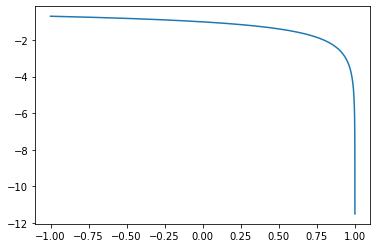

In [49]:
x = np.linspace(-1, 0.99999, 1000000)
y = log_error(x)
plt.plot(x, y);

x = 0近傍のplot

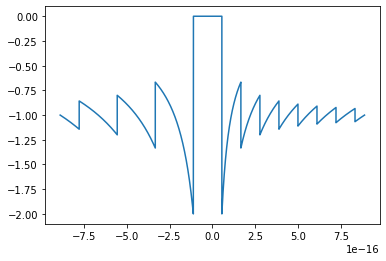

In [50]:
x = np.linspace(-2**(-50), 2**(-50), 1000000)
y = log_error(x)
plt.plot(x, y);

$\log(x)$の特徴としてxが1に近い場合、$x - 1$に近似されるので

In [51]:
def log_approx(x):
    return ((1-x)-1)/x

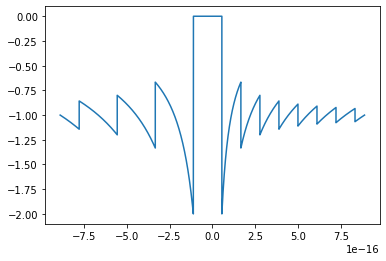

In [52]:
x = np.linspace(-2**(-50), 2**(-50), 1000000)
y = log_approx(x)
plt.plot(x, y);

桁落ちと情報落ちから発生するエラーの可視化

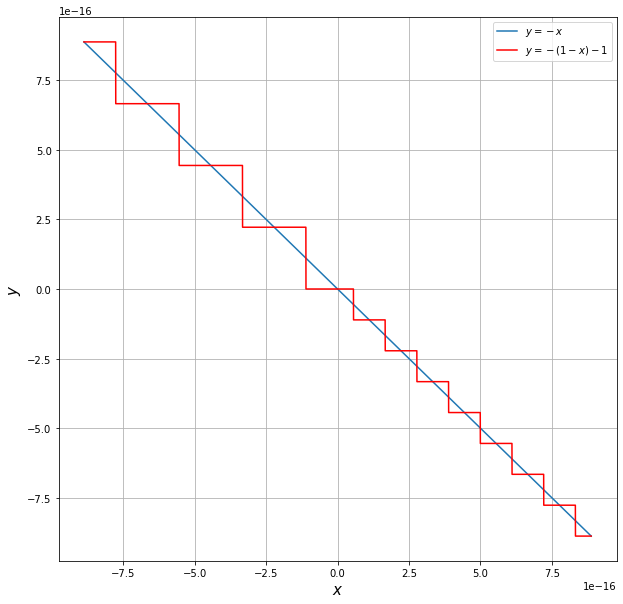

In [53]:
x = np.linspace(-2**(-50), 2**(-50), 1000000)

fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(x, -x, label = r'$y = - x$')
ax.plot(x,  (1- x) - 1, label = r'$y = - (1- x) - 1$', color = 'r')

ax.set_xlabel(r'$x$', fontsize=15)
ax.set_ylabel(r'$y$', fontsize=15)
ax.grid(True)

plt.legend(loc='upper right');

### 倍角・半角の公式と桁落ち

$$
\sin^2\left(\frac{\theta}{2}\right) = \frac{1}{2}(1 - \cos(\theta))
$$

この時も桁落ちが発生するので、$\theta$がゼロに近いときは「半角を使え」ということになる。

### 情報落ち

- 絶対値の非常に大きな数と小さな数の加減算を行ったとき、指数部が小さい方の数の仮数部の甲斐の部分が結果に反映されないために発生する誤差
- 指数部に合わせて、仮数部の桁ずらしを行なってから加減が実行される。従って両者の大きさが桁違いの場合、小さい方の情報が失われることは明らかである。この現象を情報落ちという
- 情報落ちは多数の数の加算(従って無限区間の積分など )には実際上の問題になる

In [54]:
x = 1e10
y = 1e-8

for i in range(10000000):
    x += y
print(x)

10000000000.0


このようなケースの対策として二分木法(binary search tree)が有効とされる。

### どのようなとき情報落ちが問題になるのか: varianceの計算

- 数値積分
- 分散の計算
- $x_{n + 1} = x_n + h$を計算するとき、hが$x_n$に比べ絶対値で圧倒的に小さい場合（細かい刻みで計算することの危険性を示唆）。

分散の計算と計算誤差を解説する。

In [55]:
np.random.seed(10101)
std_true = 3.08315 * 10 ** (-5)
mean_true = 10 ** 6
data = np.random.normal(mean_true, std_true, 30)
data

array([ 999999.99997509,  999999.99997793,  999999.99999831,
        999999.99999912,  999999.9999813 ,  999999.99999779,
        999999.99997219,  999999.99995532, 1000000.00001466,
        999999.99997857,  999999.99999092,  999999.99999102,
        999999.99996272, 1000000.00005677, 1000000.0000287 ,
        999999.99999036, 1000000.00000831, 1000000.00002455,
       1000000.0000504 ,  999999.99999756, 1000000.00000692,
        999999.99999431, 1000000.00000496, 1000000.00003181,
        999999.99993646,  999999.99999367,  999999.99997089,
        999999.99997622,  999999.99990064,  999999.99996814])

In [56]:
## mean calculation

s = 0
for i in data:
    s = s + i
    
x_mean = s/30
x_mean

999999.999991187

In [57]:
## variance
std = 0
for i in data:
    std += (i - x_mean)**2

std_pop = np.sqrt(std/30)
print(std_pop/std_true)

1.008149064573903


分散がマイナスになることの確認

In [58]:
square_sum = 0
for i in data:
    square_sum += i**2
    
print(square_sum/30 - x_mean**2)

-0.000244140625


### 打ち切り誤差

- 打ち切りごさは、無限回の演算を有限回で打ち切るときに発生する誤差
- フーリエ展開、ライプニッツの公式、バーゼル問題の数値計算が一例

### [例題8] ライプニッツの公式を証明せよ

$$
\frac{\pi}{4} = \sum_{k = 0}^\infty\frac{ (-1)^k}{2k + 1}
$$

#### 解
$$
\begin{align}
\frac{\pi}{4} &= \arctan(1) \\ &= \int_0^1 \frac 1{1+x^2} \, dx \\[8pt]
& = \int_0^1\left(\sum_{k=0}^n (-1)^k x^{2k}+\frac{(-1)^{n+1}\,x^{2n+2} }{1+x^2}\right) \, dx \  \ \because\text{ ここは等比数列}\\
& = \left(\sum_{k=0}^n \frac{(-1)^k}{2k+1}\right)
+(-1)^{n+1} \left(\int_0^1\frac{x^{2n+2}}{1+x^2} \, dx\right).
\end{align}
$$

Considering only the integral in the last line, we have:

$0 \le \int_0^1 \frac{x^{2n+2}}{1+x^2}\,dx \le \int_0^1 x^{2n+2}\,dx = \frac{1}{2n+3} \;\rightarrow 0 \text{ as } n \rightarrow \infty$

Therefore, by the squeeze theorem, as $n \to \infty$ we are left with the Leibniz series:

$$
\frac{\pi}4 = \sum_{k=0}^\infty\frac{(-1)^k}{2k+1}
$$

### バーゼル問題

$$
S_n = \sum^n_{i = 1} \frac{1}{i^2}
$$
を考える

$n \to \infty$の場合、

$$
\sum^\infty_{i = 1} \frac{1}{i^2}  = \frac{\pi^2}{6}
$$
が知られている（バーゼル問題）。Proof of sketchは以下、

$$
\sin x = x - \frac{1}{3!}x^3 + \frac{1}{5!}x^5 - \frac{1}{7!}x^7 + ....
$$

次に$\sin x$の因数分解をする。$n\pi$, (nは整数)の周期で$\sin n\pi = 0$となるので
$$
\begin{aligned}
\sin x = a \Pi_{n\text{は整数}}\  \ (x - n\pi) = ax \Pi_{n\text{は自然数(0は含めない)}} \  \ (x^2 - n^2\pi^2)
\end{aligned}
$$
有限時ならばaは最高次の項の係数であるが、今回は無限次なので、そのような考えは都合が悪い。そうすると

$$
x = a\left(\Pi(-n^2\pi^2)\right)x
$$

となると

$$
a = \Pi(-n^{-2}\pi^{-2})
$$
これを元の式に代入すると

$$
\sin x = x\Pi\left(1 - \frac{x^2}{n^2\pi^2}\right)
$$

3!の係数を比較すると

$$
\frac{1}{\pi^2}\left(\frac{1}{1^2} + \frac{1}{2^2} + \frac{1}{3^2} + ...\right) = \frac{1}{3!}
$$

結果、
$$
\sum^\infty_{i = 1} \frac{1}{i^2}  = \frac{\pi^2}{6}
$$

これを数値計算で表すと$1.6449340668...$となる。

### 離散化誤差

- （数値積分における台形公式、シンプソンの公式など、）連続関数の定積分の値を小さな台形の合計と捉えて数値計算することで発生する誤差

台形の公式は以下

$$
\begin{aligned}
&\int^b_a f(x) dx \approx \frac{b - a}{2n}\{ y_0 + 2(y_1 + y_2 + ... + y_{n - 1}) + y_n\}\\
&y_k = f(x_k), x_k = a + \frac{k(b - a)}{n} (k = 0, 1, ..., n)
\end{aligned}
$$

- 積分区間をn等分して、それぞれの区間の面積を台形の面積で近似する手法

### [例題9]：台形の公式
$$
\int_0^1 e^{-x^2} \, dx
$$
を台形の公式を用いて計算せよ

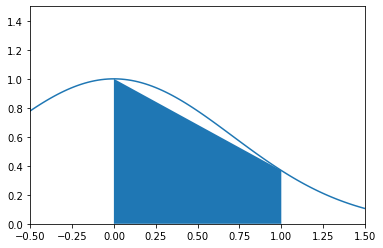

In [59]:
x = np.linspace(-0.5,1.5,100)
y = np.exp(-x**2)
plt.plot(x,y)

x0 = 0
x1 = 1
y0 = np.exp(-x0**2)
y1 = np.exp(-x1**2)

plt.fill_between([x0,x1],[y0,y1])

plt.xlim([-0.5,1.5]); plt.ylim([0,1.5]);

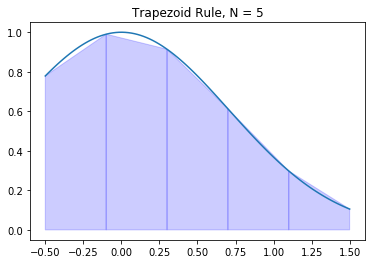

In [60]:
N = 5
x = np.linspace(-0.5,1.5,100)
y = np.exp(-x**2)
plt.plot(x,y)

X = np.linspace(-0.5,1.5, N + 1)
Y = np.exp(-X**2)


for i in range(N):
    xs = [X[i],X[i],X[i+1],X[i+1]]
    ys = [0,np.exp(-X[i]**2),np.exp(- X[i+1]**2),0]
    plt.fill(xs,ys,'b',edgecolor='b',alpha=0.2)

plt.title('Trapezoid Rule, N = {}'.format(N))
plt.show()

In [61]:
def trapz(f,a,b,N=50):
    '''
    Parameters
    ----------
    f : function
        Vectorized function of a single variable
    a , b : numbers
        Interval of integration [a,b]
    N : integer
        Number of subintervals of [a,b]

    Returns
    -------
    float
        Approximation of the integral of f(x) from a to b using the
        trapezoid rule with N subintervals of equal length.
    '''
    x = np.linspace(a,b,N+1) # N+1 points make N subintervals
    y = f(x)
    y_right = y[1:] # right endpoints
    y_left = y[:-1] # left endpoints
    dx = (b - a)/N
    T = (dx/2) * np.sum(y_right + y_left)
    return T

In [62]:
f = lambda x : np.exp(-x**2)
trapz(f, 0, 1)

0.7467996071893512

### Error formula theorem
the trapezoid rule
$$
T_N(f) = \frac{\Delta x}{2} \sum_{i=1}^N (f(x_i) + f(x_{i-1}))
$$
where $x_i = a + i \Delta x$ and $\Delta x = (b - a)/N$


Then,

$$
E_N^T(f) = \left| \ \int_a^b f(x) \ dx - T_N(f) \ \right| \leq \frac{(b-a)^3}{12 N^2} K_2
$$


where $\left| \ f''(x) \, \right| \leq K_2$ for all $x \in [a, b]$

### シンプソンの公式

- 台形公式よりも近似精度が良いとされる

$$
\begin{aligned}
&\int^b_a f(x)dx \approx \frac{b - a}{3n} \sum_{i = 1}^{n/2} y_{2i - 2} + 4y_{2i - 1} + y_{2i}\\
& y_i = f(x_i), x_i = a + \frac{k(b - a)}{n}, n \text{は偶数}
\end{aligned}
$$

#### 証明

シンプソンの公式は、$f(x)$を二次関数 $P(x)$ で近似することによって導かれる。ここで、$P(x)$は$f(x)$の a, b, m における値をそれぞれとる［m は“中点”、すなわち $(a+b)/2$］。$P(x)$ は、ラグランジュ補間によって、次の多項式（x の二次式）になることがわかる。

$$
P(x) = f(a) \frac{(x - m)(x - b)}{a - m)(a - b)} + f(m) \frac{(x - a)(x - b)}{m - a)(m - b)} + f(b) \frac{(x - a)(x - m)}{b - m)(b - m)}
$$

これを範囲$[a, b]$で積分すると、

$$
\int^b_a f(x)dx \approx \int^b_a P(x)dx =  \frac{b - a}{6} \left[f(a) + 4f\left(\frac{a + b}{2}\right) + f(b)\right]
$$

が得られる。積分範囲を小さな部分区間に分割し、各部分区間についてシンプソンの公式を適用し、その結果を足し合わせることで上の公式が得られる

なお、$f(x)$が3次式以下なら次式が成り立つ

$$
\frac{b - a}{6} \left[f(a) + 4f\left(\frac{a + b}{2}\right) + f(b)\right]
$$


証明は$f(x) = 1, x, x^2, x^3$でそれぞれで上の式が成り立つことを示せば良い。

#### (1) $f(x) = 1$

$$
\int^b_a f(x) = b - a 
$$

一方

$$
\frac{b - a}{6} \left[f(a) + 4\left(\frac{a + b}{2}\right) + f(b)\right] = \frac{b - a}{6} (1 + 4 + 1) = b - a
$$

#### (2) $f(x) = x$

$$
\int^b_a f(x) = \frac{1}{2}[b^2 - a^2] 
$$

一方

$$
\frac{b - a}{6} \left[a + 4\left(\frac{a + b}{2}\right) + b \right] = \frac{1}{2}(b - a)(a + b) = \frac{1}{2}[b^2 - a^2] 
$$

#### (3) $f(x) = x^2$

$$
\int^b_a f(x) = \frac{1}{3}[b^3 - a^3] 
$$

一方

$$
\frac{b - a}{6}[2a^2 + 2ab + 2b^2] = \frac{1}{3}(b^3 - a^3)
$$

#### (3) $f(x) = x^3$

$$
\int^b_a f(x) = \frac{1}{4}[b^4 - a^4] 
$$

一方

$$
\frac{b - a}{6} \left(a^3 + \frac{(a + b)^3}{2} + b^3\right) = \frac{b - a}{12}(3a^3 + 3b^3 + 3a^2b + 3ab^2) = \frac{1}{4}(b^4 - a^4)
$$

途中の計算は交代式


#### 交代式の因数分解

- 交代式とは，どの2つの変数を入れ替えても −1倍になるような式のことです。例えば $a^2−b^2$という式は，a と b を入れ替えると $b^2−a^2$ となり，元の式の −1 倍になるので交代式です。
- 対称式とは，どの2つの変数を入れ替えても元の値と変わらない式のこと

$$
a^4−b^4=(a−b)(a^3+a^2b+ab^2+b^3)
$$

$$
a^n+b^n=(a+b)(a^{n-1}-a^{n-2}b+\cdots-ab^{n-2}+b^{n-1})
$$


### [例題10] シンプソンの公式

シンプソンの公式を用いて、

$$
\int^1_0 3x^2 dx
$$

を計算せよ

In [63]:
def simp(f, a, b, N):
    '''
    Simpson's rule approximates the integral \int_a^b f(x) dx by the sum:
    (dx/3) \sum_{k=1}^{N/2} (f(x_{2i-2} + 4f(x_{2i-1}) + f(x_{2i}))
    where x_i = a + i*dx and dx = (b - a)/N.
    '''
    if N % 2 == 1:
        raise ValueError("N must be an even integer.")
    
    dx = (b-a)/N
    x = np.linspace(a,b,N+1) # 区間をN個
    y = f(x)
    S = dx/3 * np.sum(y[0:-1:2] + 4*y[1::2] + y[2::2])
    return S

In [64]:
simp(lambda x: 3*x**2, 0, 1, 50)

1.0

### 打ち切り誤差とeps

$$
f(x) = x^3  - 15.70875 x^2 + 61.69729x - 0.04844725
$$

が与えられたときf(x) = 0を満たすxを求めたいとする。このとき`abs(f(x)) < eps`を満たすようなxを探索し、その結果を返す関数を作ると思うが問題は`eps`をどのように定めるべきかである。


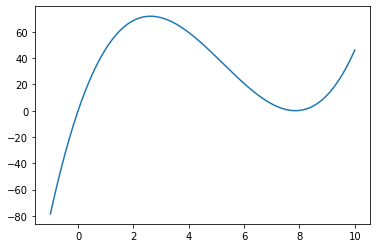

In [65]:
a = 1
b = -15.70875
c = 61.69729
d = -0.04844725

f = lambda x : a * x**3 + b * x**2 + c * x + d
x = np.linspace(-1, 10, 1000)
y = f(x)

plt.plot(x,y);

In [66]:
root_1 = optimize.bisect(f, -1, 2, maxiter = 10000)
root_2 = optimize.bisect(f, 7, 7.85, maxiter = 10000)
root_3 = optimize.bisect(f, 7.85, 10, maxiter = 10000)

print(root_1, root_2, root_3)

0.0007853981828702672 7.844763307419362 7.863201294396229


x = 0.0007853981828702672付近での誤差の見積もり

なお10進７桁四捨五入計算とする

In [67]:
c * root_1 * 10**(-6)/2

2.4228469727009954e-08

よってf(x)には$\pm 2.5\times 10^{-8}$くらいの誤差が混入する可能性があり、`abs(f(x))`が$10^{-8}$のオーダーになったならば、それ以上細かくxを調整することはナンセンスということがわかる。

同様に、それ以外のrootでの誤差のオーダーを計算するとそれぞれ$10^{-3}, 10^{-2}$程度の精度しか期待できないことがわかる。


このことは$|x^{(v)} - x^{(v - 1)}| < \epsilon$がいかに使いづらいものかを示している。

### 計算のもっともらしさTips: 刻みを変えて計算する

$$
I = \int^1_0 \frac{1}{1 + x}dx = \log 2
$$
を台形則を用いて計算する。

In [68]:
a = 0
b = 1
f = lambda x: 1/(1 + x)

trapz(f,a,b,N=16)

0.6933912022075269

この一回だけの計算だけでは誤差については分からないが

In [69]:
data = None

for i in range(1, 6):
    N = 2**i
    half_N = N/2
    num, I_N, I_half = N, trapz(f, a, b, N = N), trapz(f, a, b, N = half_N)
    tmp = np.array([num, I_N, I_half, abs(I_N - I_half)])
    if data is None:
        data = tmp
    else:
        data = np.vstack([data, tmp])
    
data = pd.DataFrame(data, columns = ('num', 'I_N', 'I_half', 'diff'))
data['num'] = data['num'].astype('int')
data

,num,I_N,I_half,diff
0,2,0.708333,0.750000,0.041667
1,4,0.697024,0.708333,0.011310
2,8,0.694122,0.697024,0.002902
3,16,0.693391,0.694122,0.000731
4,32,0.693208,0.693391,0.000183


台形則による計算の数値誤差はNが十分大きいと以下の式で近似できる；

$$
I_N - I \approx c/N^2
$$

これを変形させると

$$
I_{(N/2)} - I_N \approx 3(I_N - I) \approx 3c/N^2
$$

よって数値計算誤差をさらに減らすことが可能となり

In [70]:
trapz(f,a,b,N=32) - data.loc[4, 'diff']/3

0.6931472102898231

これだけではなく、`trapz`の定式化を間違えた時も、それぞれの区間数でのdiffの縮小具合を見ることで計算の間違いに気づくことができる。例として、diffがどの区間数を選んでも0.001で変わらない時は、台形則の誤差のルールを満たしておらず元々の関数がおかしいという示唆を与えてくれる。

### 収束速度の加速

- Aitken's Delta squared method
- 収束速度がlinearな数列に適応可能な手法


#### Definition: 収束速度

Suppose the sequence $\{p_n\}_{n=0}^\infty$ converges to p, with $p_n \neq p$ for all n. If positive constants λ and α exists with

$$
\lim_{n \to \infty}\frac{|p_{n+1} - p|}{|p_{n} - p|} = \lambda
$$

then $\{p_n\}_{n=0}^\infty$ converges to p of order α, with asymptotic error constant λ.


#### Aitken’s ∆2 Methodの導出

$\{p_n\}_{n = 0}^\infty$がlinearly convergent sequence with limit pと仮定する。また$sign(p_{n} - p) = sign(p_{n - 1} - p)$とする。

Then, 十分大きなnに対して

$$
\frac{|p_n - p|}{|p_{n - 1}- p|} \approx \frac{|p_{n-1} - p|}{|p_{n - 2}- p|} \approx \lambda
$$

式変形すると

$$
(p_{n - 1} - p)^2 \approx (p_n - p)(p_{n - 2} - p)
$$

これをpについて解くと

$$
p \approx = \frac{p_np_{n - 2} - p_{n-1}^2}{p_n - 2p_{n-1} + p_{n - 2}}
$$

Then,

$$
p = p_{n} - \frac{(p_n - p_{n - 1})^2}{p_n - 2p_{n-1} + p_{n - 2}}
$$

#### REMARK: Steffensen’s Method

- Aiktin's methodをfixed point interationと組み合わせると二乗収束のroot-findingアルゴリズムが作成できる = Steffensen’s Method
- newton法と比べ、derivativeも必要ない
- ただし$f\in C^3[a, b]$が要求される

## 演習問題

### [1-1]
2進数01101000を10進数で表せ

In [71]:
binary_to_decimal('01101000')

104

### [1-2]
10進数72を2進数で表せ

In [72]:
decimal_to_binary(72)

'1001000'

### [1-3]
2進数0.011を10進数であらわせ

In [73]:
binary_to_decimalpoint(0.011)

0.375

### [1-4]
10進数0.3125を2進数で表せ

In [74]:
decimal_to_binarypoint(0.3125, iterator = 10)

'0.0101'

### [2-2]
次のIEEE形式浮動小数点数が表す値を答えよ

```
1 01111111 10000000000000000000000
```

In [75]:
s = 1
e = 127 - 127
m = 1.5

print((-1 ** s) * (2 ** e) * m)

-1.5


### [4-1]
IEEE単精度浮動小数点数で表される最大の数Mの10進法における桁数を求めよ

In [76]:
res = int(np.log(2.0 * (2 ** (254 - 127)))/ np.log(10)) + 1
print('10進法における桁数は{}'.format(res))

10進法における桁数は39


### [6-1]

真の値3.141592に対して近似値が3.14であるとき絶対誤差、相対誤差、精度は何桁か？

In [77]:
true = 3.141592
approx = 3.14

abs_error = abs(approx - true)
relative_error = abs_error/true
precision = -np.log10(relative_error)

print(round(abs_error, 7), round(relative_error, 7), int(precision))

0.001592 0.0005067 3


### [7] 二次方程式の解の公式と桁落ち対策

解の公式

$$
x = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
$$

をそのまま計算すると桁落ちのリスクがある。これを回避する手法を実装せよ。

#### [解]

```
INPUT
    a, b, c : 二次方程式の係数（xのorderが高い順で並べている）

OUTPUT
    x0, x1: 解
    
ALGORITHM
    1. x0 = [-b - sign(b)*sqrt(b^2 - 4ac)]/2a
    2. x1 = (c/a * x0)
    3. return x0, x1
```

In [78]:
def qeq(a, b, c):
    d = np.sqrt(b**2 - 4*a*c)
    alpha = (-b - np.sign(b)*d)/(2 * a)
    beta = c/(a * alpha)
    return (alpha, beta)

In [79]:
qeq(1, 5, 6)

(-3.0, -2.0)

### [8]

The number π = 3.14159265358979... If we use the approximation π ≈ 3.14, what is the absolute error? Express your answer using chopping to a decimal normalized floating-point representation with 5 significant digits.

#### [解]

- fl: round functon, decimal normalized floating-point representation with 5 significant digits.

$$
fl(abs(\pi - 3.14)) = fl(0.0015926535...) = 10^{-2}\times 0.15926
$$

### [9] 

The hexadecimal (base 16) counting system uses letters A, B, C, D, E, and F in addition to decimal digits (from 0 to 9) to represent digits for 10, 11, 12, 13, 14, and 15, correspondingly. Find the hexadecimal representation of the decimal number 2989.

In [80]:
def decimal_to_hex(x):
    decimal_list = np.arange(0, 16)
    hex_list = np.arange(0, 10).astype(str)
    hex_list = np.hstack((hex_list, 'A', 'B', 'C', 'D', 'E', 'F'))
    hex_dict = dict(zip(decimal_list, hex_list))
    
    quotient, remainder = divmod(x, 16)
    res = str(hex_dict[remainder])
    while quotient > 0:
        quotient, remainder = divmod(quotient, 16)
        res = str(hex_dict[remainder]) + res
    
    return res

In [81]:
decimal_to_hex(2989)

'BAD'

### [10]

In the IEEE double-precision floating-point standard, 64 bits (binary digits) are used to rep- resent a real number: 1 bit for the sign, 11 bits for the exponent, and 52 bits for the man- tissa. A double-precision normalized non-zero number x can be written in this standard as $x = ±(1.d1d2···d52)2 ×2^{n−1023}$, with 1 ≤ n ≤ 2046, and 0 ≤ dk ≤ 1 for k = 1,2,...,52.

- (a) What is the smallest positive number in this system? 
- (b) What is the smallest negative number in this system? 
- (c) How many real numbers are in this system?


In [82]:
### (a)

x = 2 ** -1023
print('the smallest positive number is {}'.format(x))

the smallest positive number is 1.1125369292536007e-308


In [83]:
### (b)

x = -1 *  2 ** 1023 * (2 - 2 ** -52)
print(x)

-1.7976931348623157e+308


In [84]:
### (c)

print(2 * 2046 * 2 ** 52 + 1)

18428729675200069633


最後の + 1 はzeroの分を加えたもの

### [11]

In this assignment, you will evaluate the accuracy of Stirling’s famous approximation.

$$
n! \approx n^n\exp(-n)\sqrt{2\pi n}
$$

Write a program to output a table of the form

`n, n!, Stirling’s approximation, Absolute error, Relative error`

for n = 1,2,...,10. Judging from the table, does the accuracy increase or decrease with increasing n?

In [85]:
import math

In [86]:
def stirling_approx(n):
    approx = n**n * np.exp(-n) * np.sqrt(2*np.pi*n)
    true = math.factorial(n)
    abs_error = abs(approx - true)
    relative_error = abs_error/true
    return n, true, approx, abs_error, relative_error

def sterling_approx_table(max_counter):
    i = 1
    res = []
    while i <= max_counter:
        tmp = list(stirling_approx(i))
        res.append(tmp)
        i += 1
    
    return pd.DataFrame(res, columns = ['n', 'factorial', 'Stirlings_approximation', 'Absolute error', 'Relative error'])


In [87]:
sterling_approx_table(max_counter = 10)

,n,factorial,Stirlings_approximation,Absolute error,Relative error
0,1,1,9.221370e-01,0.077863,0.077863
1,2,2,1.919004e+00,0.080996,0.040498
2,3,6,5.836210e+00,0.163790,0.027298
3,4,24,2.350618e+01,0.493825,0.020576
4,5,120,1.180192e+02,1.980832,0.016507
5,6,720,7.100782e+02,9.921815,0.013780
6,7,5040,4.980396e+03,59.604168,0.011826
7,8,40320,3.990240e+04,417.604547,0.010357
8,9,362880,3.595369e+05,3343.127158,0.009213
9,10,3628800,3.598696e+06,30104.381259,0.008296


### [12]

$\pi$を近似計算する。

<img src = "https://github.com/RyoNakagami/omorikaizuka/blob/master/algorithm/update_rule_pi.jpg?raw=true">

In [88]:
def approx_pi(n):
    L = 1
    res = []
    i = 1
    j = 6
    while i <= n:
        if i == 1:
            tmp = j * L/2
            res.append([j, L, tmp])
        else:
            j = j * 2
            L = np.sqrt(2 - np.sqrt(4 - L**2))
            tmp = j*L/2
            res.append([j, L, tmp])
        i += 1
    return res

In [89]:
pd.DataFrame(approx_pi(30), columns = ['n', 'L', 'pi'])

,n,L,pi
0,6,1.000000e+00,3.000000
1,12,5.176381e-01,3.105829
2,24,2.610524e-01,3.132629
3,48,1.308063e-01,3.139350
4,96,6.543817e-02,3.141032
5,192,3.272346e-02,3.141452
6,384,1.636228e-02,3.141558
7,768,8.181208e-03,3.141584
8,1536,4.090613e-03,3.141590
9,3072,2.045307e-03,3.141592


途中からround_errorと桁落ちによる数値誤差が発生しへんな値になる。桁落ち対策を施した数値計算方法を次に実装する。

In [90]:
def approx_pi_adj(n):
    L = 1
    res = []
    i = 1
    j = 6
    while i <= n:
        if i == 1:
            tmp = j * L/2
            res.append([j, L, tmp])
        else:
            j = j * 2
            L = np.sqrt(L**2 / (2 + np.sqrt(4 - L**2)))
            tmp = j*L/2
            res.append([j, L, tmp])
        i += 1
    return res

In [91]:
data = pd.DataFrame(approx_pi_adj(30), columns = ['n', 'L', 'pi'])
data['abs_error'] = abs(np.pi - data['pi'])
data['relative_error'] = data['abs_error']/np.pi
data

,n,L,pi,abs_error,relative_error
0,6,1.000000e+00,3.000000,1.415927e-01,4.507034e-02
1,12,5.176381e-01,3.105829,3.576411e-02,1.138407e-02
2,24,2.610524e-01,3.132629,8.964040e-03,2.853343e-03
3,48,1.308063e-01,3.139350,2.242451e-03,7.137942e-04
4,96,6.543817e-02,3.141032,5.607027e-04,1.784772e-04
5,192,3.272346e-02,3.141452,1.401813e-04,4.462110e-05
6,384,1.636228e-02,3.141558,3.504568e-05,1.115539e-05
7,768,8.181208e-03,3.141584,8.761441e-06,2.788853e-06
8,1536,4.090613e-03,3.141590,2.190362e-06,6.972138e-07
9,3072,2.045307e-03,3.141592,5.475905e-07,1.743035e-07
